# Lab 1 - Introduction

This notebook introduces some basic python functions to deal with geospatial data.

It is part of the Spatial Cluster Analisis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
There are many ways to create beautiful maps in Python using packages such as *folium* or *plotly*. In this notebook, the `plot` functionality of *geopandas* is illustrated, which is sufficient for most of our purposes. The functionality will be illustrated with two sample data sets provided by the GeoDa data repository from the Center of Spatial Data Science (University of Chicago). One is the **Liquor** sample data set that contains the location of the liquor stores in Chicago, IL, as . This data was scraped from Google Maps in 2015 and contains 2 variables and 571 observations. Available at: https://geodacenter.github.io/data-and-lab/liq_chicago/ . The second is a small data set with the Chicago Community Area Population and Percent Change for 2000 and 2010. It is based on 77 observations and 8 variables. Available at: https://geodacenter.github.io/data-and-lab/commpop/.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the following specification:

Specifically in this notebook, only geopandas and matplotlib will be explicitly used. This conda environment, however, is already prepared for our next class.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

### Load data

We start with some simple examples that use the Chicago Community Area data.

List of variables:
| Column Name | Description                                                                                      |
|-------------|--------------------------------------------------------------------------------------------------|
| community   | Neighborhood name                                                                               |
| NID         | Neighborhood ID                                                                                 |
| POP2010     | Census population 2010                                                                          |
| POP2000     | Census population 2000                                                                          |
| POPCH       | Population count change                                                                         |
| POPPERCH    | Population percentage change                                                                    |
| popplus     | Binary variable (1 if a positive population change is observed between 2000 and 2010)           |
| popneg      | Binary variable (1 if a negative population change is observed between 2000 and 2010)           |


The following files will be used:
- **chicago_comm_utm.shp,shx,dbf,prj**: shape file (four files) for 77 community areas


In [3]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Chicago community area data:
chi_comm = gpd.read_file(path+"chicago_commpop/chicago_commpop.shp")
print(chi_comm.shape)
chi_comm.head(3)

(77, 9)


,community,NID,POP2010,POP2000,POPCH,POPPERCH,popplus,popneg,geometry
0,DOUGLAS,35,18238,26470,-8232,-31.099358,0,1,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,OAKLAND,36,5918,6110,-192,-3.142390,0,1,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,FULLER PARK,37,2876,3420,-544,-15.906433,0,1,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."


## Getting Started

Once the data is loaded as a **GeoDataFrame**, a basic plot function can be called from the object to show the polygons loaded from the shapefile:

<Axes: >

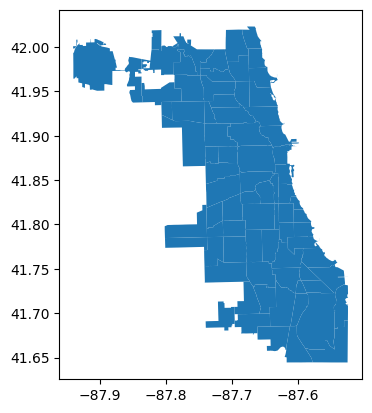

In [4]:
chi_comm.plot()

The community area shapefile also contains information on the population and population change of each community area, in addition to other varibles.

We can use this information to create a choropleth map. Before delving into customization, the default choropleth map created by the `plot` function applied to a **GeoDataFrame** is illustrated. A bare bones implementation only requires the variable (column) to be mapped and the argument `legend = True`. Without the latter, there will still be a map, but it will not have a legend, so there will be no guide as to what the colors mean.

In the example, we will use the percentage population change variable, "POPPERCH". Note that population totals should be avoided in thematic maps, since they are so-called spatially extensive variables (larger values in larger areas, everything being the same). One should always aim to map spatially intensive variables, such as densities, percentages, per capital values, etc. The variable is set to `plotvar`, which makes it easy to recreate the maps for other variables. One only needs to replace the specification of `plotvar`.

In [7]:
plotvar = 'POPPERCH'

<Axes: >

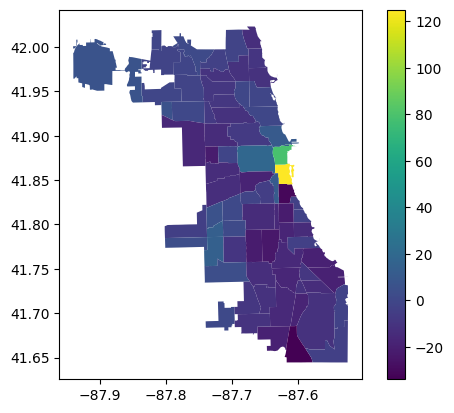

In [9]:
chi_comm.plot(plotvar,legend=True)

### Matplotlib Logic

The *matplotlib* library is extremely powerful and allows just about any type of customized visualization. It starts by setting up the basic parameters and then builds a graphic representation layer by layer. The terminology may seem a bit strange at first, but after a while, it becomes more familiar.

A plot is initialized by assigning some parameters to the tuple `fig , ax`. It is important to realize that `fig` is about the figure makeup and `ax` is about the actual plots. For example, `fig` is used to specify how many subplots there need to be, how they are arranged and what their size is. Since the examples used here and in later notebooks will only produce a single plot, the `fig` aspect can be ignored and only `ax` is needed. In fact, for simple plots such as the maps in our applications, the specification of `ax` as such is not needed and the `plot` function can be applied directly to the GeoDataFrame. However, it remains important that the plot object is referred to as `ax` in many operations.

An alternative way to set up the default map just shown is to explicitly assign it to an object `ax`, as `ax = chi_comm.plot( )` with the same arguments as before. To remove the x-y coordinates and box around the map, the method `set_axis_off()` is applied to the `ax` object. Using this setup also removes the **<Axes: >** listing. Otherwise, everything is still the same as before.

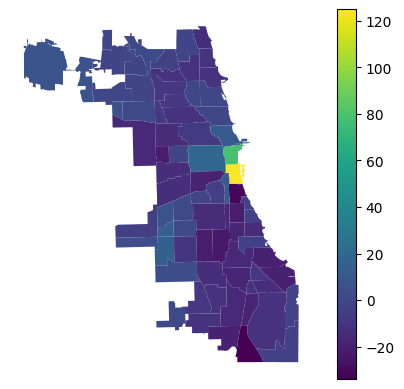

In [10]:
ax = chi_comm.plot(plotvar,legend = True)
ax.set_axis_off()

## Map Design Characteristics

The purpose of a choropleth or thematic map is to visualize the spatial distribution of a variable over areal units. Choropleth comes from the Greek choros, which stands for region, so it is a map for regions. For our purposes, the proper design of a map has three important characteristics, which each translate into arguments to the `plot` function:

- classification

- color

- legend

### Classification

Arguably the most important characteristic is the classification used, i.e., how the continuous distribution of a given variable gets translated into a small number of discrete categories, or bins. This is exactly the same issue encountered in the design of histogram bins.

The assignment of observations to distinct bins is done by the *mapclassify* library, which is part of the *PySAL* family. However, this is done under the hood by *geopandas* so that no separate `import` statement is needed.

The classification is set by means of the `scheme` argument. Common options are `Quantiles` (for a quantile map), `EqualInterval` (for an equal intervals map), `NaturalBreaks` (for a natural breaks map), `StdMean` (for a standard deviational map), and `BoxPlot` (for a box map). All but the last two classifications require an additional argument for the number of bins, `k`. This is not needed for the standard deviational map and the box map, for which the breakpoints are derived from the data, respectively the standard deviation and the quartiles/hinge.

The default hinge for the box map is 1.5 times the interquartile range. Other values for the hinge can be specified by setting a different value for the argument `hinge`, but this is typically not necessary. However, to pass this to the *geopandas* `plot` function it cannot just be set as `hinge = 3.0` as in *mapclassify*. In *geopandas* it is necessary to pass this in a `classification_kwds` dictionary, where the relevant parameters are set. For example, this would be `classification_kwds = {"hinge": 3.0}` for a hinge of 3 times the interquartile range.

The default for the standard deviational map is to show all observations within one standard deviation below and above the mean as one category. To separate observations below and above the mean can be accomplished by setting the argument `anchor` to `True`. Again, this is done by means of the `classification_kwds` dictionary.

Full details on all the classifications available through *mapclassify* and their use in *geopandas* can be found at https://geopandas.org/en/stable/docs/user_guide/mapping.html# and https://pysal.org/mapclassify/api.html.

Each of the five cases is illustrated in turn. Note that the `column` argument is used to designate the variable to be mapped.

The placement of the legend is managed by means of the `legend_kwds` argument (similar to `classification_kwds`). This is a dictionary that specifies aspects such as the location of the legend and how it is positioned relative to its anchor point. It also makes it possible to set a `title` for the legend, e.g., to set it to the variable that is being mapped.

In the examples, the following arguments are used: `legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": "<variable name>"}`. This is not totally intuitive, but it works. See https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html#matplotlib.axes.Axes.legend for details about the various legend customizations.

Also note that the map uses the default color map. More appropriate color maps will be considered below.

#### Quantile Map

A simple six category quantile map is illustrated by setting `scheme = "Quantiles"` and `k=6`. The `legend` arguments now also include a `title`. In addition, two `ax` methods are used for a minor customization: `ax.set_title` to give the map a title and, as before, `ax.set_axis_off` to get rid of the box with x-y coordinates.

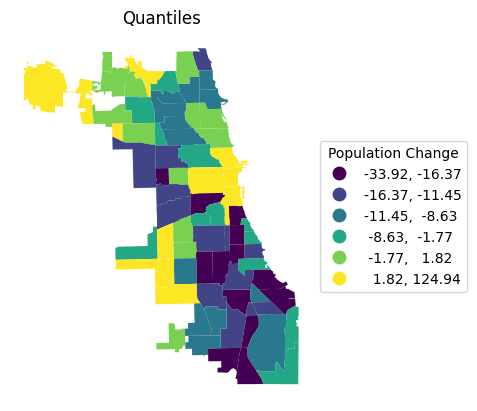

In [12]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'Quantiles',
    k = 6,
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title" : "Population Change"}
)
ax.set_title("Quantiles")
ax.set_axis_off()

#### Maps with Set Number of Bins

Rather than repeating the single command for each type of map that needs the argument `k`, a small loop is constructed that creates each in turn. This is accomplished by putting the name for the respective `scheme` in a list and using that same name as the map title. The three types are `Quantiles`, `EqualInterval` and `NaturalBreaks`.

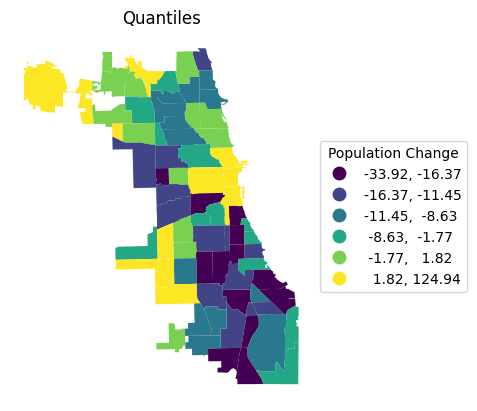

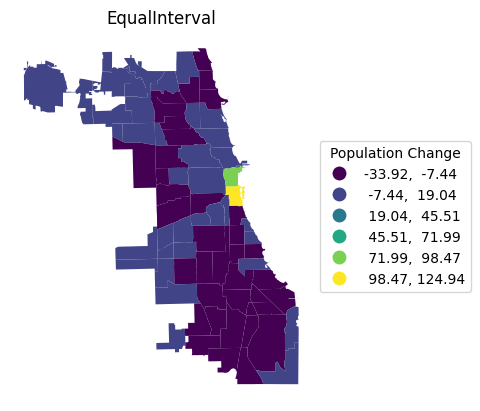

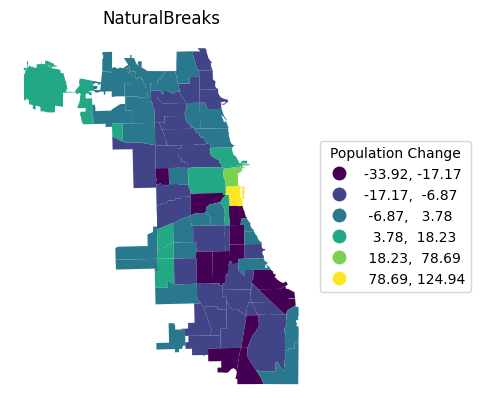

In [13]:
schemek = ["Quantiles","EqualInterval","NaturalBreaks"]
for i in schemek:
    ax = chi_comm.plot(
    column = plotvar,
    scheme = i,
    k = 6,
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": "Population Change"}
    )
    ax.set_title(i)
    ax.set_axis_off()

Note the contrast in the visualization of the spatial distribution between the different classifications. It is important to keep in mind that each has pros and cons. For example, the quantile map yields an equal number of observations in each category, but the range of the categories can vary subtantially, resulting in the grouping of very disparate observations. In the example, this is the case for the top category, which ranges from 1.8 to 124.9. 

The range in an equal intervals map is the same for all categories, but as a result some bins may have very few or very many observations, as is the case here for the lowest bins.

Finally, a natural breaks map uses an optimization criterion (essentially equivalent to k-means on one variable) to determine the grouping of observations. Both the number of observations in each bin and the range of the bins is variable.

#### Maps with Predetermined number of Bins

The standard deviational map and box map have a pre-set number of bins, depending on, respectively, standard deviational units and quantiles/interquantile range. Again, they are illustrated using a small loop.

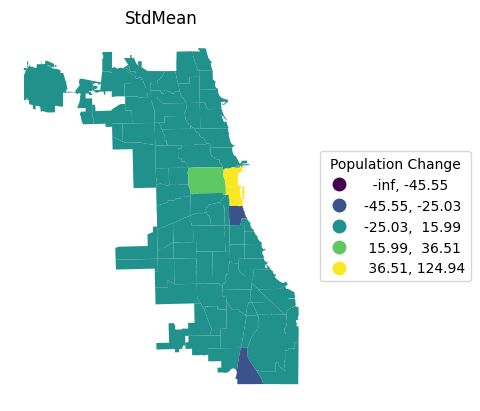

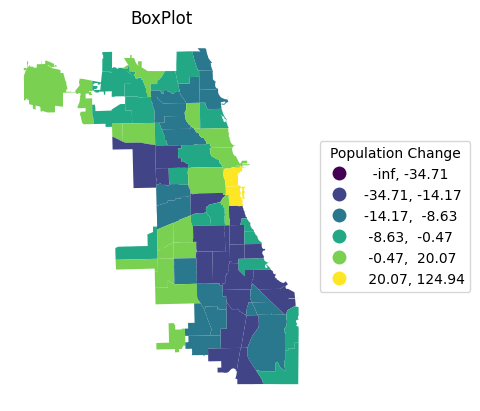

In [14]:
schemenok = ["StdMean","BoxPlot"]
for i in schemenok:
    ax = chi_comm.plot(
    column = plotvar,
    scheme = i,
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
    )
    ax.set_title(i)
    ax.set_axis_off()

Both types of maps are designed to highlight outliers. In the standard deviational map, these are observations more than two standard deviations away from the mean, in the box map, the outliers are outside the hinge (1.5 times the interquartile range from the median). This can be customized by setting a different value for the hinge through the `classification_kwds` argument. For example, selecting only the most extreme observations is achieved by setting `classification_kwds = {"hinge": 3.0}`, as illustrated below.

Note that since the bins are created based on deviations from the mean or median, the low ranges can start at -inf, which doesn't really make sense.

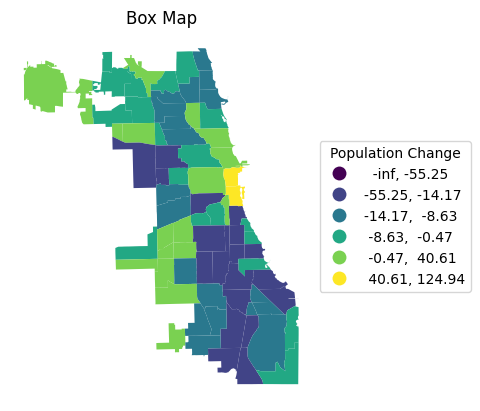

In [15]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'BoxPlot',
    k = 6,
    classification_kwds = {'hinge': 3.0},
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": "Population Change"}
)
ax.set_title("Box Map")
ax.set_axis_off()

To avoid the negative bins, we can use the argument `classification_kwds = {"anchor" : True}` to ensure the lower boundary of the classification starts at 0 or the minimum value in the data. A standard deviational map with the categories below and above the mean shown is implemented with `classification_kwds = {"anchor" : True}`, as shown below.

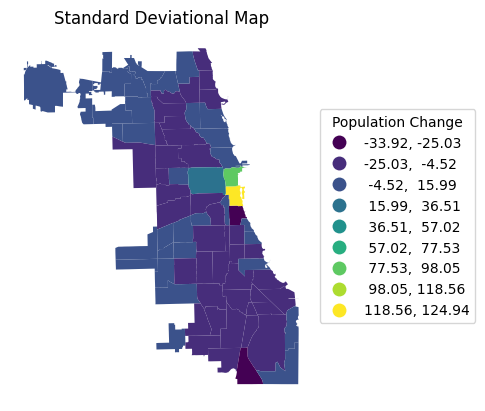

In [16]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'StdMean',
    k = 6,
    classification_kwds = {'anchor': True},
    legend = True,
    legend_kwds = {"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Standard Deviational Map")
ax.set_axis_off()

Whereas the first three types of classifications have a color scheme that suggests a progression from low to high values, a so-called *sequential* legend, the standard deviational map and box map focus on differences from a central value. This requires a color map that highlights the move away from the center, a so-called *diverging* legend. In the examples shown so far, the categories were shown with the default sequential color map, which is not appropriate. The needed customizations are considered next.

### Color Map

The color scheme for the map is set by means of the `cmap` argument. This refers to a *matplotlib* color map, i.e., a pre-determined range of colors optimized for a particular purpose. For example, this allows for a different color map to represent a sequential vs. a diverging legend.

The full range of color maps can be found at https://matplotlib.org/stable/users/explain/colors/colormaps.html.

For our purposes, a good sequential color map uses a gradation that goes from light to dark, either in the same color, such as `cmap="Blues"`, or moving between colors, such as `cmap="YlOrRd"`. For a diverging legend, going from one extreme color to another is preferred, e.g., dark blue to light blue and then to light red and dark red, as in `cmap="bwr"`, or even more extreme, as in `cmap="seismic"`.

Some examples are shown below.

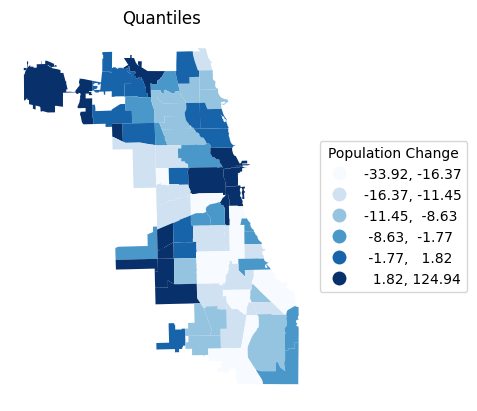

In [17]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'Quantiles',
    k = 6,
    cmap = 'Blues',
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Quantiles")
ax.set_axis_off()

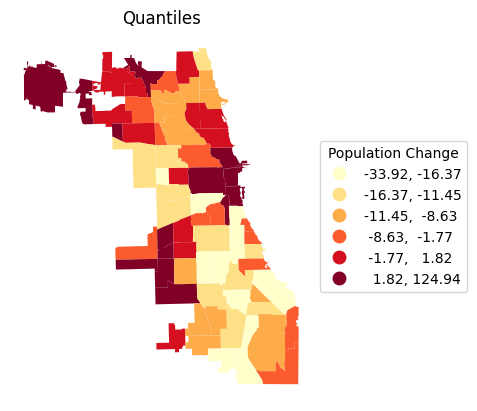

In [18]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'Quantiles',
    k = 6,
    cmap = 'YlOrRd',
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Quantiles")
ax.set_axis_off()

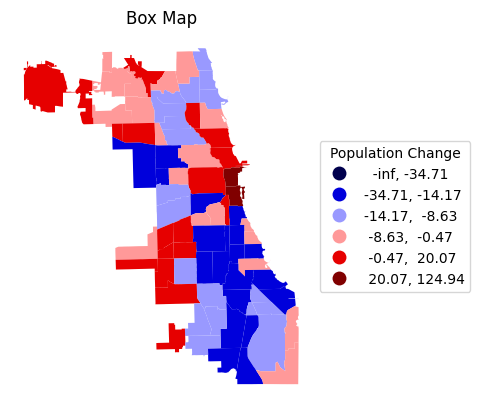

In [19]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'BoxPlot',
    cmap = 'seismic',
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Box Map")
ax.set_axis_off()

But notice when this is applied to the standard deviational map with `cmap = bwr`.

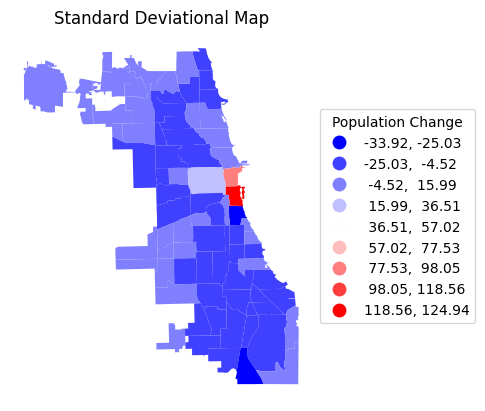

In [20]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'StdMean',
    classification_kwds = {'anchor': True},
    cmap = 'bwr',
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Standard Deviational Map")
ax.set_axis_off()

This map is fine, except that it becomes difficult to see the boundaries between community areas. The reason is that there is no borderline specified for the map. This final customization is considered next.

### Final Customization

As mentioned, the full range of *matplotlib* customizations is available to manipulate legends, colors and placement. For our purposes, one more map-specific element is of interest. As seen in the previous examples, the border between polygons is not clear or even non-existent. 

This can be fixed by setting the `edgecolor` and associated `linewidth` attributes. For example, with `edgecolor = "Black"`, the standard deviational map becomes more meaningful.

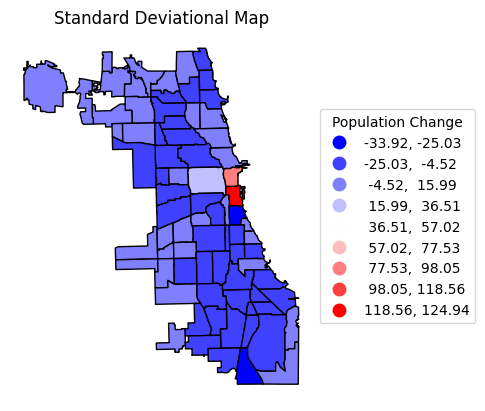

In [21]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'StdMean',
    classification_kwds = {'anchor': True},
    cmap = 'bwr',
    edgecolor = "Black",
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Standard Deviational Map")
ax.set_axis_off()

#### Saving the Map to a File

So far, the maps are generated in the notebook, but are not separately available. To save a specific map to a file, the `matplotlib.pyplot.savefig` command is used. For example, to save the standard deviational map (or any other map) to a png format file, only the filename needs to be specified as an argument to `plt.savefig`. Optionally, to get higher quality figures, the number of dots per inch can be set by means of `dpi`. 

This is illustrated for the standard deviational map where a more subtle border line is obtained by setting the thickness with `linewidth = 0.2`. The quality is set to `dpi = 600`.

The file will be in the current working directory.

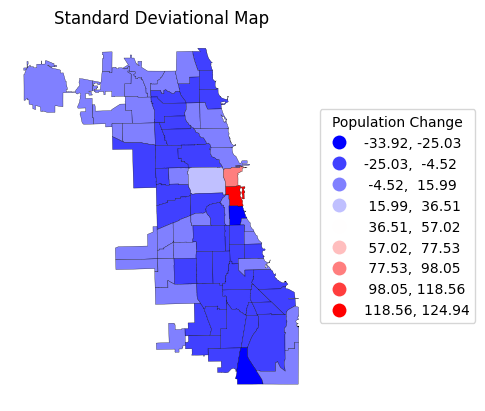

In [22]:
ax = chi_comm.plot(
    column = plotvar,
    scheme = 'StdMean',
    classification_kwds = {'anchor': True},
    cmap = 'bwr',
    edgecolor = "Black",
    linewidth = 0.2,
    legend = True,
    legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": 'Population Change'}
)
ax.set_title("Standard Deviational Map")
ax.set_axis_off()
plt.savefig("popchange_stdmean.png",dpi=600)

Finally, a map with just the community area borders is obtained with the `boundary.plot` command, where the color of the border line is controlled by `edgecolor` and the line thickness by `linewidth`, as before.

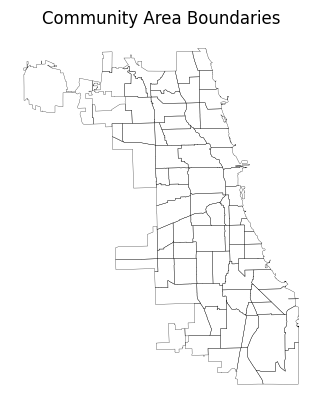

In [23]:
ax = chi_comm.boundary.plot(
    edgecolor = "Black",
    linewidth = 0.2,
)
ax.set_title("Community Area Boundaries")
ax.set_axis_off()

## Point Data

So far, in this example, we used a shapefile containing polygon or discrete spatial data. Alternatively, we can plot point data, which can be loaded the same way as before from a shapefile, or from a spreadsheet as a .CSV file. 

In the following examples, we will the location of the liquor stores in Chicago, IL. Files used:

- **liq_Chicago.shp,shx,dbf,prj**: shape file (four files) for 571 data points


In [25]:
# Load the Chicago liquor store data:
point_df = gpd.read_file(path+"liquor/liq_Chicago.shp")
print(point_df.shape)
point_df.head(3)

(571, 3)


,id,placeid,geometry
0,0,ChIJnyLZdBTSD4gRbsa_hRGgPtc,MULTIPOINT (1161395.91 1928443.285)
1,3,ChIJ5Vdx0AssDogRVjbNIyF3Mr4,MULTIPOINT (1178227.792 1881864.522)
2,4,ChIJb5I6QwYsDogRe8R4E9K8mkk,MULTIPOINT (1178151.911 1879212.002)


As before, a simple visualization of the data can be obtained with the `.plot` function. Here, we add two optional arguments: `markersize=4` and `color='blue'`, which control the size of the dots on the map and their color.

<Axes: >

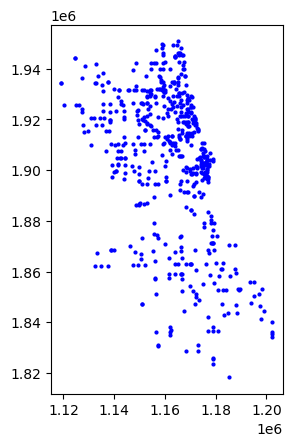

In [26]:
point_df.plot(markersize=4, color='blue')

The simple visualization lacks spatial context for the point data. To overlay the points on the community areas, we can use the `ax` parameter in the `plot()` function to specify the same axes for both plots. However, before combining these two, we must certify they are based on the same projection.

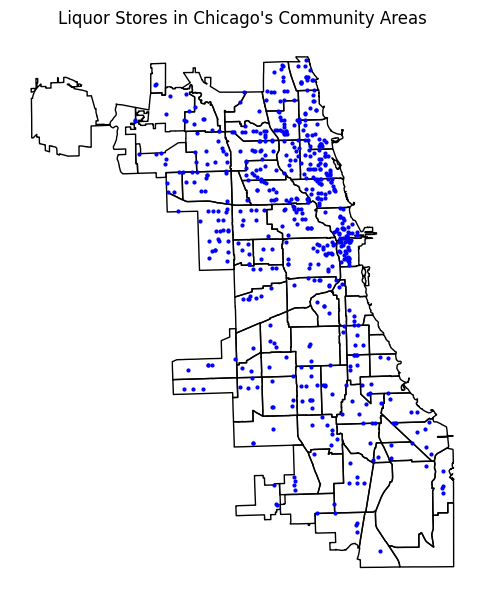

In [27]:
# Converting the projection of the community areas shape to the same as the liquor stores shape:
chi_comm = chi_comm.to_crs(point_df.crs)

# Plotting the figure with both layers:
fig, ax = plt.subplots(figsize=(6, 8))
chi_comm.plot(ax=ax, color='none', edgecolor='black') 
point_df.plot(ax=ax, markersize=4, color='blue')
ax.set_title("Liquor Stores in Chicago's Community Areas")
ax.set_axis_off()
plt.show()

## Practice

Use your own data set or one of the GeoDa Center or PySAL sample data sets to load a spatial data frame and experiment with various map types, color schemes and other customizations. Save each map to a file for inclusion in papers, reports, etc.